In [1]:
import os
import numpy as np
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# STEP 1. 형태소 분석기를 이용하여 명사 추출하기

def read_token(file_name):
    okt = Okt()
    result = []
    # 파일 경로: 환경변수 HOME 아래 aiffel/weat 폴더에 있음
    file_path = os.path.join(os.getenv('HOME'), 'aiffel', 'weat', file_name)
    with open(file_path, 'r', encoding='utf-8') as fread:
        print(f"{file_name} 파일을 읽고 있습니다.")
        while True:
            line = fread.readline()
            if not line:
                break
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word, pos in tokenlist:
                if pos in ["Noun"]:
                    result.append(word)
    return ' '.join(result)

# 장르 파일 목록과 장르 이름 (총 21개)
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', 
              '미스터리', '범죄', '사극', '서부극(웨스턴)', '성인물(에로)', '스릴러', '애니메이션', 
              '액션', '어드벤처', '전쟁', '코미디', '판타지']

genre = []
for file in genre_txt:
    tokenized_text = read_token(file)
    genre.append(tokenized_text)
print("텍스트 처리 완료!")

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.
텍스트 처리 완료!


In [4]:
# STEP 2. 추출된 결과로 embedding model 만들기
tokenized_genre = [text.split() for text in genre]
model = Word2Vec(tokenized_genre, vector_size=100, window=5, min_count=3, sg=0)
print("Word2Vec 모델 학습 완료!")

# STEP 3. TF-IDF로 대표 단어 셋 만들기 (중복 단어 제거 개선 포함)

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(genre)
print("TF-IDF 계산 완료! X_tfidf shape:", X_tfidf.shape)

# feature_names: 각 컬럼에 해당하는 단어 리스트
feature_names = vectorizer.get_feature_names()

# 각 장르별 상위 100개 단어 후보 추출
top_k = 100
genre_top_words = []
for i in range(X_tfidf.shape[0]):
    row = X_tfidf[i].tocoo()
    word_scores = [[col, data] for col, data in zip(row.col, row.data)]
    word_scores.sort(key=lambda x: x[1], reverse=True)
    words = [feature_names[idx] for idx, score in word_scores[:top_k]]
    genre_top_words.append(words)

# 각 장르별로 대표 단어 15개 선정 (다른 장르와 중복되지 않는 단어 우선)
top_n = 15
attributes = []
for i in range(len(genre_name)):
    other_words = set()
    for j in range(len(genre_name)):
        if i != j:
            other_words.update(genre_top_words[j])
    unique_words = [word for word in genre_top_words[i] if (word not in other_words) and (word in model.wv)]
    if len(unique_words) < top_n:
        fallback = [word for word in genre_top_words[i] if word in model.wv]
        unique_words = fallback[:top_n]
    else:
        unique_words = unique_words[:top_n]
    attributes.append(unique_words)
    print(f"{genre_name[i]} 대표 단어:", unique_words)


Word2Vec 모델 학습 완료!
TF-IDF 계산 완료! X_tfidf shape: (21, 42191)
SF 대표 단어: ['외계', '행성', '시스템', '생명체', '스타크', '리플리', '과학자', '파괴', '켈빈', '컨트', '수퍼맨', '외계인', '분파', '연구', '개발']
가족 대표 단어: ['아주르', '낙타', '씨제이', '동구', '슈이트', '마갈', '미아', '펠리칸', '벤트', '케이시', '크리스마스', '최호', '혜지', '유나', '테리']
공연 대표 단어: ['실황', '올레', '오텔로', '리골레토', '백작', '프레', '베르디', '비바', '콘서트', '백작부인', '반니', '아리아', '미노', '차이코프스키', '라다']
공포(호러) 대표 단어: ['시작', '위해', '사람', '자신', '친구', '그녀', '사건', '공포', '발견', '죽음', '마을', '가족', '악령', '남자', '좀비']
기타 대표 단어: ['영화제', '국제', '서울', '단편', '영화', '자신', '사람', '이야기', '그녀', '남자', '위해', '시작', '사랑', '뉴미디어', '페스티벌']
다큐멘터리 대표 단어: ['다큐', '다큐멘터리', '기록', '카메라', '투쟁', '인디다큐페스티발', '지금', '현재', '문화', '건축', '인터뷰', '중국', '변화', '운동', '자연']
드라마 대표 단어: ['자신', '영화제', '그녀', '사람', '사랑', '영화', '위해', '시작', '국제', '남자', '친구', '이야기', '엄마', '여자', '아버지']
멜로로맨스 대표 단어: ['애인', '남자친구', '선배', '커플', '고백', '동거', '이혼', '시아버지', '만남', '은밀', '첫사랑', '직장', '언니', '형부', '매일']
뮤지컬 대표 단어: ['뮤지컬', '에스메랄다', '충무로', '모차르트', '니웨', '바흐', '페뷔스', '프롤', '

(예술영화/일반영화 파일 처리 중...)
synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.
예술/일반 영화 TF-IDF 계산 완료! X_artgen shape: (2, 41082)
예술영화를 대표하는 단어 후보 (상위 100개):
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어 후보 (상위 100개):
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 

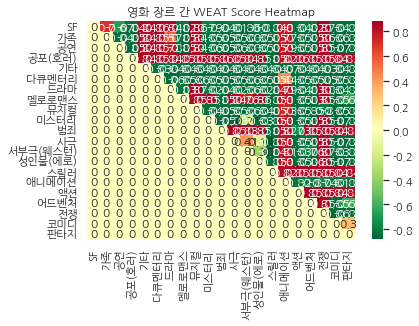

In [5]:
# STEP 4. TF-IDF를 이용해 예술영화 vs. 일반영화 코퍼스에서 target 단어 셋 추출 및 WEAT Score 계산/시각화

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token_simple(file_name):
    # STEP 1과 동일한 함수 (간단하게 사용)
    okt = Okt()
    result = []
    file_path = os.path.join(os.getenv('HOME'), 'aiffel', 'weat', file_name)
    with open(file_path, 'r', encoding='utf-8') as fread:
        print(f"{file_name} 파일을 읽고 있습니다.")
        while True:
            line = fread.readline()
            if not line:
                break
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word, pos in tokenlist:
                if pos in ["Noun"]:
                    result.append(word)
    return ' '.join(result)

print("(예술영화/일반영화 파일 처리 중...)")
art = read_token_simple(art_txt)
gen = read_token_simple(gen_txt)

# TF-IDF를 통해 art와 gen의 대표 단어 후보 추출
vectorizer_artgen = TfidfVectorizer()
X_artgen = vectorizer_artgen.fit_transform([art, gen])
print("예술/일반 영화 TF-IDF 계산 완료! X_artgen shape:", X_artgen.shape)

m1 = X_artgen[0].tocoo()  # art의 sparse matrix
m2 = X_artgen[1].tocoo()  # gen의 sparse matrix

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]
w1.sort(key=lambda x: x[1], reverse=True)
w2.sort(key=lambda x: x[1], reverse=True)

print('예술영화를 대표하는 단어 후보 (상위 100개):')
for i in range(100):
    print(vectorizer_artgen.get_feature_names()[w1[i][0]], end=', ')
print('\n')
    
print('일반영화를 대표하는 단어 후보 (상위 100개):')
for i in range(100):
    print(vectorizer_artgen.get_feature_names()[w2[i][0]], end=', ')
print('\n')

n = 15
w1_ = [vectorizer_artgen.get_feature_names()[w1[i][0]] for i in range(100)]
w2_ = [vectorizer_artgen.get_feature_names()[w2[i][0]] for i in range(100)]

target_art = []
target_gen = []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv):
        target_art.append(w1_[i])
    if len(target_art) == n:
        break 
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv):
        target_gen.append(w2_[i])
    if len(target_gen) == n:
        break

print("최종 예술영화 target 단어:", target_art)
print("최종 일반영화 target 단어:", target_gen)

# WEAT score 계산 함수
def weat_score(X, Y, A, B):
    def s_w_A_B(w, A, B):
        return np.mean([cosine_similarity(w.reshape(1, -1), a.reshape(1, -1))[0][0] for a in A]) - \
               np.mean([cosine_similarity(w.reshape(1, -1), b.reshape(1, -1))[0][0] for b in B])
    s_X = np.mean([s_w_A_B(w, A, B) for w in X])
    s_Y = np.mean([s_w_A_B(w, A, B) for w in Y])
    std_XY = np.std([s_w_A_B(w, A, B) for w in np.concatenate((X, Y), axis=0)])
    return (s_X - s_Y) / std_XY if std_XY != 0 else 0

# target 단어들의 임베딩 벡터 구성
X_target = np.array([model.wv[word] for word in target_art])
Y_target = np.array([model.wv[word] for word in target_gen])

# 각 장르 간 attribute 집합으로 WEAT Score 계산
n_genres = len(genre_name)
matrix = [[0 for _ in range(n_genres)] for _ in range(n_genres)]
print("WEAT Score 계산 중...")
for i in range(n_genres - 1):
    for j in range(i+1, n_genres):
        A_attr = np.array([model.wv[word] for word in attributes[i] if word in model.wv])
        B_attr = np.array([model.wv[word] for word in attributes[j] if word in model.wv])
        matrix[i][j] = weat_score(X_target, Y_target, A_attr, B_attr)
print("WEAT Score 계산 완료!")

# WEAT Score 결과 출력
for i in range(n_genres - 1):
    for j in range(i+1, n_genres):
        print(f"{genre_name[i]} - {genre_name[j]}: {matrix[i][j]:.2f}")

# Heatmap 시각화
sns.set(font='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True, cmap='RdYlGn_r')
plt.title("영화 장르 간 WEAT Score Heatmap")
plt.show()


## 회고 

예술영화 target 단어와 일반영화 target 단어가 많이 겹치는거같아서 팀원들과 이야기를 해봤음. 그 결과 예술, 영화가 반대로 결과가 출력된 팀원도 있었고 
tfidf, lda 방식을 사용한 팀원들끼리도 결과가 많이 다르게 나오는 등 결과적으로 최종 타겟 단어가 중요한거 같음

처음 다뤄보는 분야라 개념을 다루는데 어려움을 겪었음
